# Data Exploration Part 1

This notebook investigates simple statistics of the dataset.


In [1]:
from cell_segmentation.data.generate_statistics import GenerateStatistics
import pandas as pd
import matplotlib.pyplot as plt

import os
import pathlib

if "notebooks" in pathlib.Path.cwd().parts:
  while "notebooks" in pathlib.Path.cwd().parts:
    os.chdir('..')
    print('current directory: ', os.getcwd())


train_df = pd.read_csv('data/train.csv')

current directory:  /home/letruong/projects/sartorius-cell-instance-segmentation


In [2]:
categorical_stats, numerical_stats= GenerateStatistics.get_statistics(train_df, numeric_columns=['width', 'height'], categorical_columns=['cell_type'])
print("numerical statistics")
print(numerical_stats)
print('\n')
print("categorical statistics")
print(categorical_stats)

numerical statistics
         width   height
count  73585.0  73585.0
mean     704.0    520.0
std        0.0      0.0
min      704.0    520.0
25%      704.0    520.0
50%      704.0    520.0
75%      704.0    520.0
max      704.0    520.0


categorical statistics
cell_type
shsy5y       52286
cort         10777
astro        10522
dtype: int64


<AxesSubplot:title={'center':'Distribution of cell types'}>

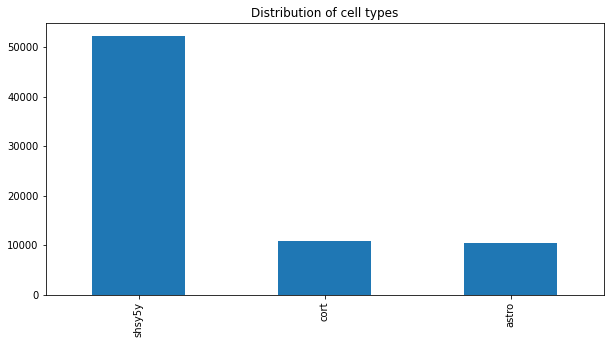

In [3]:
train_df['cell_type'].value_counts(sort=True).plot.bar(title='Distribution of cell types', figsize=(10,5))

This plot clearly shows we have more samples of the cell type `shsy5y` than `cort` or `astro`. `cort` or `astro` are of close amounts. This indicates an imbalanced dataset.

shsy5y (SH-SY5Y) cell type: also known as Neuroblastoma, a type of cancer that forms in certain types of nerve tissue.
astro: also known as Astrocytes, star shaped. They perform helpful functions to support the functionality and repair.
cort: also known as Neurons

https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/282544

# Investigate Annotations

In [4]:
# annotation area and statistics
from cell_segmentation.data.converter.satorius2coco import Satorius2COCO
from cell_segmentation.data.datasets import Datasets
from cell_segmentation.data.loader import Loader
from cell_segmentation.utils.configs import load_config

config = "experiments/mask_rcnn/configs/train.yaml"
cfg = load_config(config)
data_loader = Loader(cfg)
satorius_converter = Satorius2COCO()
df = data_loader.load_static_dataset(filepath=cfg.DATASETS.TRAIN_STATIC_FILE)
df = data_loader.preprocess_static_dataset(df)

train_df, val_df = Datasets.generate_examples(
    df,
    seed=cfg.SEED,
    train_split=cfg.DATASETS.TRAIN_SPLIT,
    test_split=cfg.DATASETS.TEST_SPLIT,
)
train_dataset = data_loader.build_microscopyimage_from_dataframe(train_df)
validation_dataset = data_loader.build_microscopyimage_from_dataframe(val_df)

# Distribution of train vs validation

ensure we sample from similar distributions of real-world data. Especially the test set, so we understand real-world performance. In absence of this knowledge, we assume the train set is similar distribution to real-world population.

<AxesSubplot:title={'center':'Distribution of cell types'}>

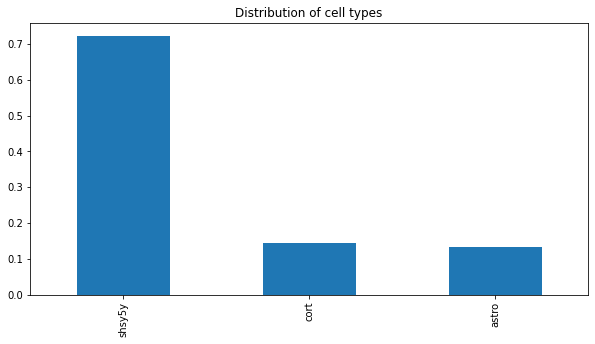

In [35]:
train_df['cell_type'].value_counts(normalize=True, sort=True).plot.bar(title='Distribution of cell types', figsize=(10,5))

<AxesSubplot:title={'center':'Distribution of cell types'}>

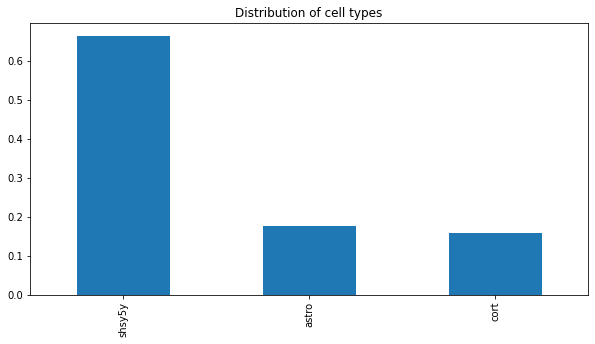

In [34]:
val_df['cell_type'].value_counts(normalize=True, sort=True).plot.bar(title='Distribution of cell types', figsize=(10,5))

# Average area per cell type

Understanding the average area of a cell type will assist when evaluate the IoU metric when investigating small, medium and large object instances in an image. 

and then within what range a certain cell size can be. This can possible indicate the a confusion of cell type if the model is attempting to detect a specific cell type by size. 

in addition, if using mask-rcnn, this information assists in selecting the right anchor sizes.

In [13]:

df = pd.DataFrame(columns=["cell_type", "area"])
for example in train_dataset:
    for annotation in example.annotations:
        if annotation:
            df = df.append({'cell_type': annotation.segmentation.label, 'area': annotation.segmentation.area}, ignore_index=True)

cell_types = ["astro", "shsy5y", "cort"]
for cell_type in cell_types:
    df[df['cell_type']==cell_type].plot.hist(title=f"{cell_type}", figsize=(10,5))
    plt.show()
        

# Mean area per cell type

similar as previous, to understand size when investigating IoU metric.

In [15]:
df.groupby(['cell_type']).agg({'area': 'mean'}).reset_index()

,cell_type,area
0,astro,871.748949
1,cort,237.938497
2,shsy5y,224.714146


# Number of annotations per image

This will assist in the configuration of the model, restrict to certain number of proposals and also adjust in inference as default mask rcnn is 100 instance predictions. 

In [56]:
images = {}
for example in train_dataset:
    if example.file_id not in images.keys():
        images[example.file_id] = len(example.annotations)

average_annotations_per_image = sum(images.values())/ len(images.values())
print(f"min annotations per image: {min(images.values())}")
print(f"max annotations per image: {max(images.values())}")
print(f"average annotations per image: {average_annotations_per_image:.2f}")

min annotations per image: 5
max annotations per image: 790
average annotations per image: 125.79
